In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/akkirr/annotated-diffusion


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path

import torch
from torch import nan_to_num
from torchvision import transforms as T
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image
import requests

from datasets import load_dataset
from torchvision.utils import save_image
from torch.optim import Adam

In [3]:
from mylib import *
import mylora

In [4]:
sampler = Sampler(linear_beta_schedule, 300)

In [13]:
settings = Settings(
    results_folder = Path("./4-results-lora-exps-2"),
    image_size = 28,
    channels = 1,
    batch_size = 128,
    device = "cuda" if torch.cuda.is_available() else "cpu",
    checkpoint = 'checkpoints/2-trained-on-1:last.pt'
)

In [6]:
settings.results_folder.mkdir(exist_ok = True)

In [7]:
dataset = load_dataset("fashion_mnist")
# define image transformations (e.g. using torchvision)
transform = Compose([
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).filter(lambda x: x['label'] == 0).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=settings.batch_size, shuffle=True)

Found cached dataset fashion_mnist (/home/akkirr/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/akkirr/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-e1de293369d54b3d.arrow
Loading cached processed dataset at /home/akkirr/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-99238c540bf086fb.arrow


In [8]:
model = Unet(
    dim=settings.image_size,
    channels=settings.channels,
    dim_mults=(1, 2, 4,)
)
model.to(settings.device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [9]:
model.load_state_dict(torch.load('checkpoints/2-trained-on-1:last.pt'))

<All keys matched successfully>

In [10]:
mylora.set_all_seeds()
samples = sampler.sample(model, image_size=settings.image_size, batch_size=64, channels=settings.channels)

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

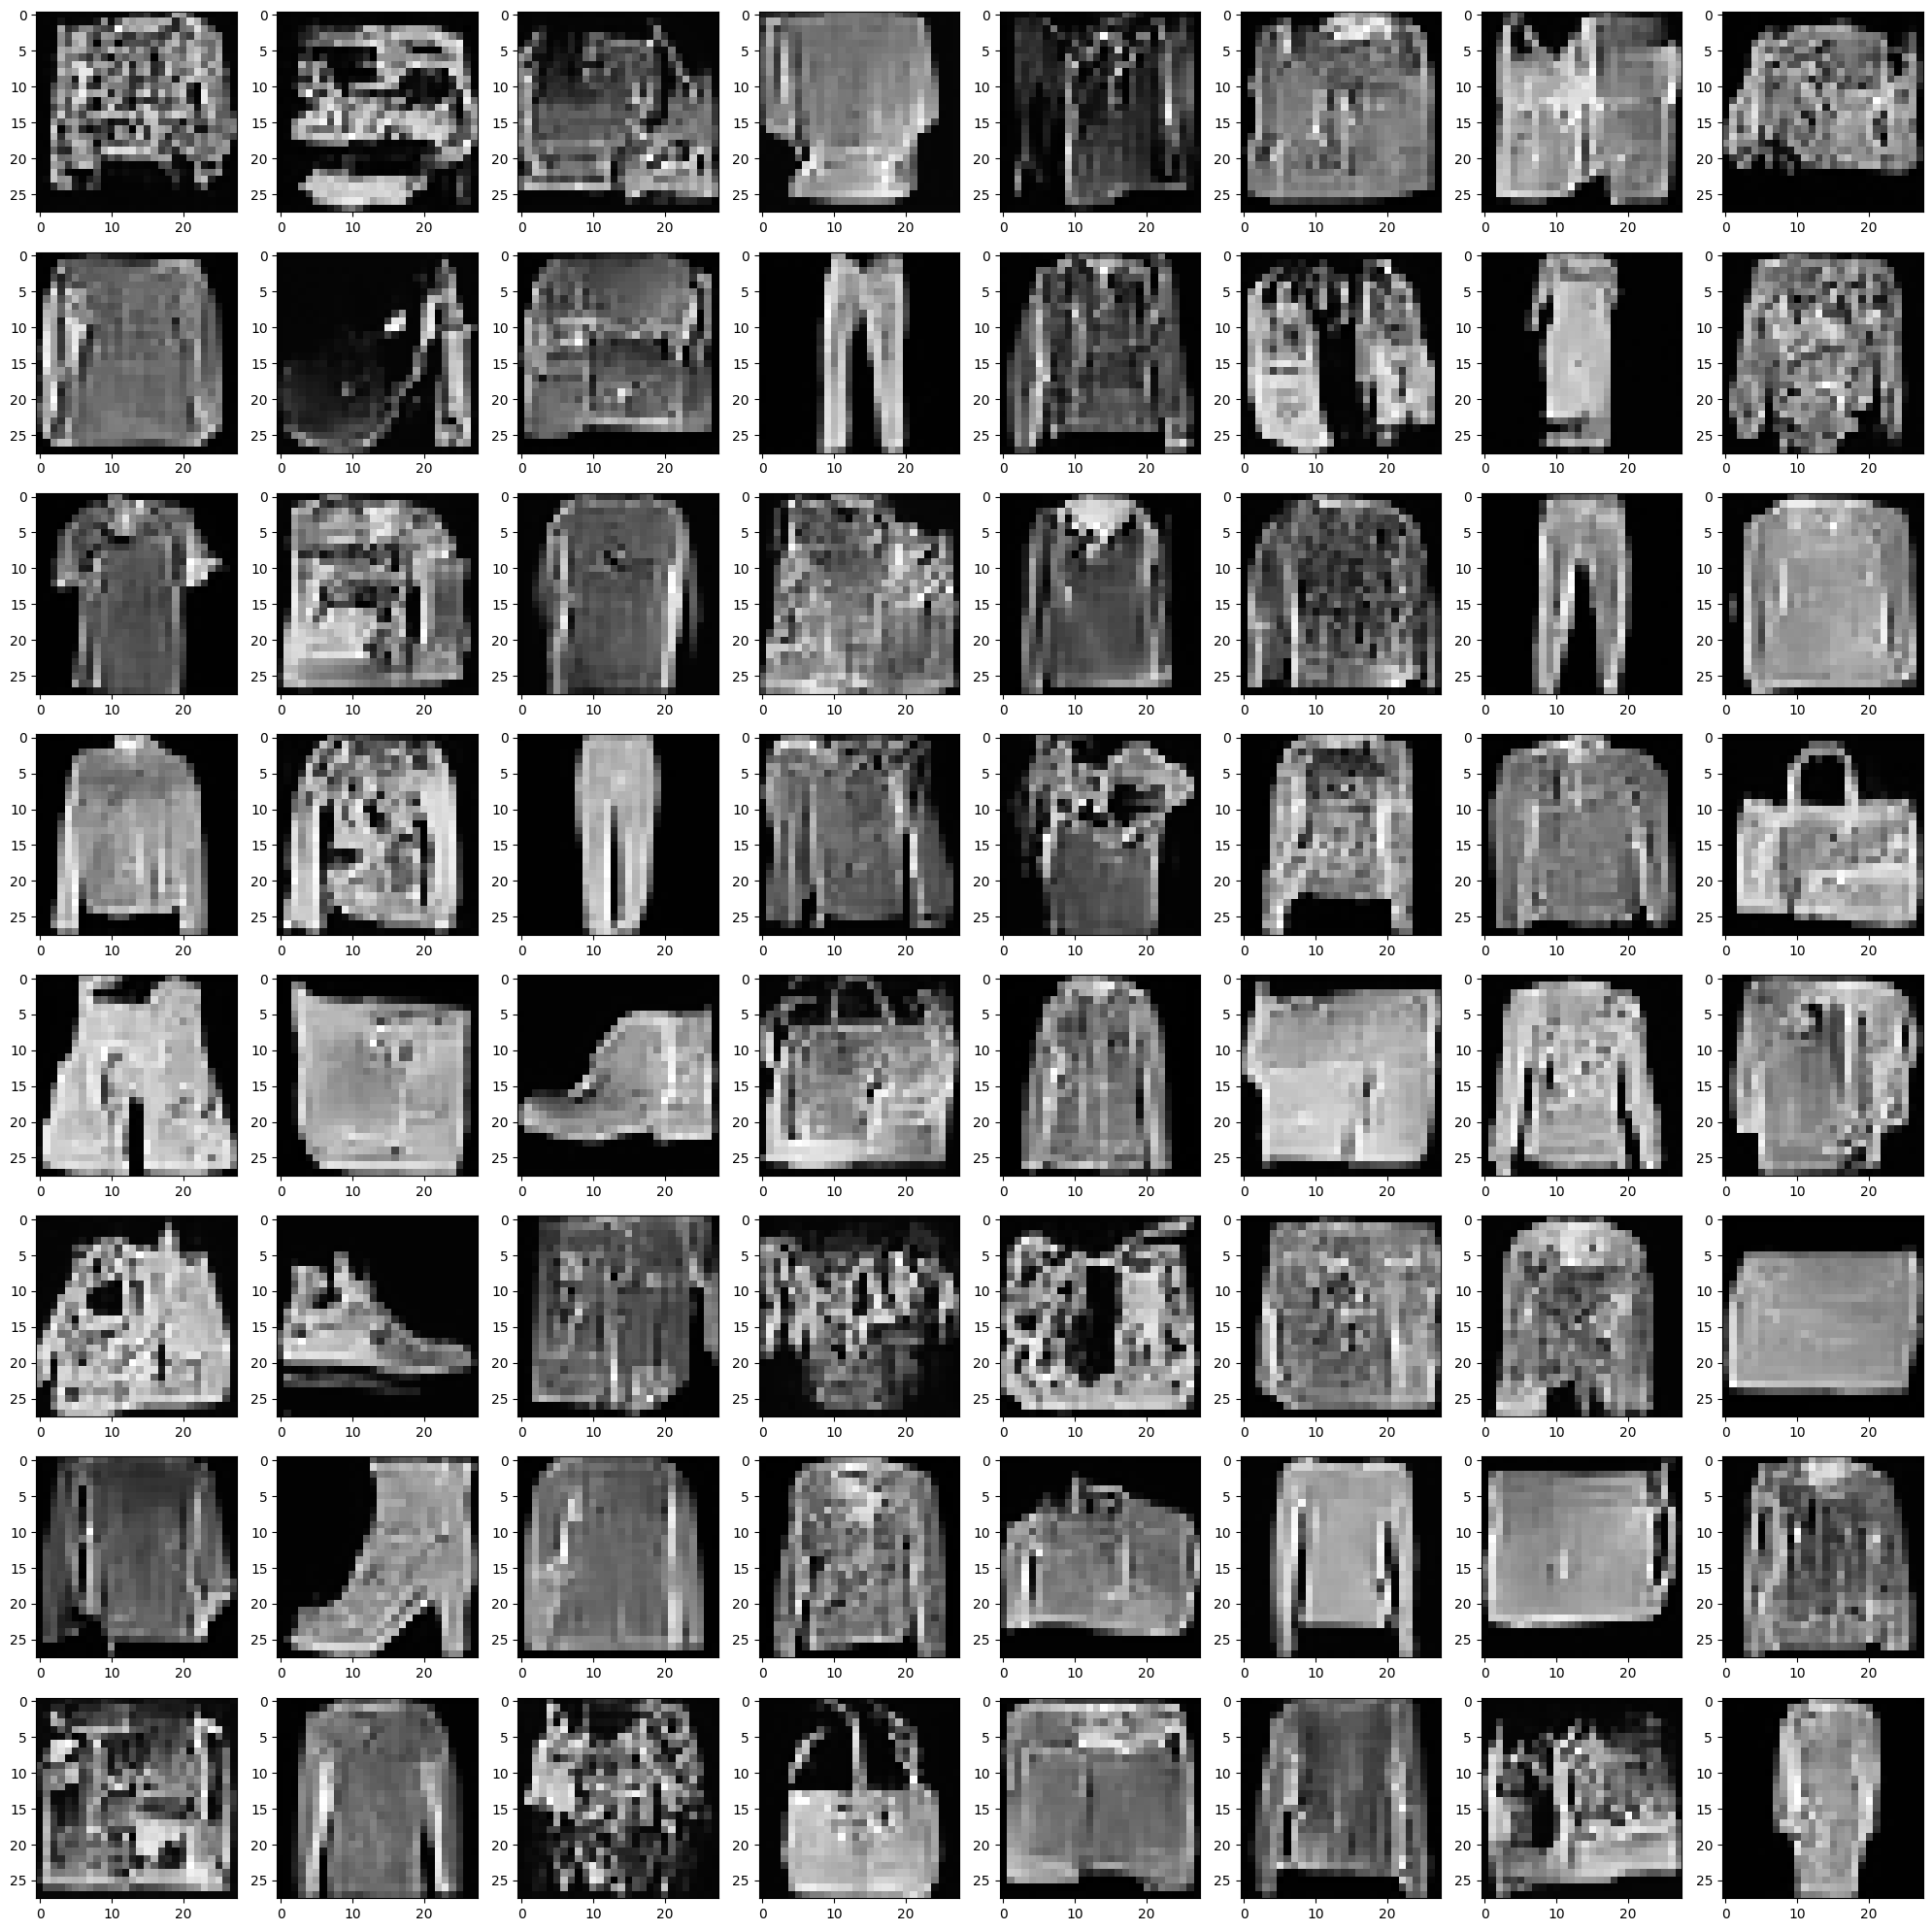

In [12]:
plot_images(samples, settings)

# My version and official version are the same

### Mylora 1

In [101]:
from copy import deepcopy

In [102]:
mylora.set_all_seeds()
model = Unet(
    dim=settings.image_size,
    channels=settings.channels,
    dim_mults=(1, 2, 4,)
)
model.load_state_dict(torch.load(settings.checkpoint))

mylora.inject_lora(
    model, 1, 0.1,
    ['LinearAttention'],
    [nn.Conv2d]
)
model.to(settings.device)

mylora.freeze_lora(model)
mylora.model_summary(model)

Injected lora    28 x 1 x 384   in downs.0.2.fn.fn.to_qkv
Injected lora   128 x 1 x 28    in downs.0.2.fn.fn.0
Injected lora    28 x 1 x 384   in downs.1.2.fn.fn.to_qkv
Injected lora   128 x 1 x 28    in downs.1.2.fn.fn.0
Injected lora    56 x 1 x 384   in downs.2.2.fn.fn.to_qkv
Injected lora   128 x 1 x 56    in downs.2.2.fn.fn.0
Injected lora   112 x 1 x 384   in ups.0.2.fn.fn.to_qkv
Injected lora   128 x 1 x 112   in ups.0.2.fn.fn.0
Injected lora    56 x 1 x 384   in ups.1.2.fn.fn.to_qkv
Injected lora   128 x 1 x 56    in ups.1.2.fn.fn.0
Injected lora    28 x 1 x 384   in ups.2.2.fn.fn.to_qkv
Injected lora   128 x 1 x 28    in ups.2.2.fn.fn.0
trainable layers:            24
frozen layers:              231
total params:           2023945


In [103]:
state_dict1 = deepcopy(model.state_dict())

In [104]:
optimizer = Adam(model.parameters(), lr=1e-3)
train(model, optimizer, dataloader, sampler, settings, epochs=1)

Loss: 0.038884326815605164


In [105]:
state_dict2 = deepcopy(model.state_dict())

### Mylora 2

In [106]:
mylora.set_all_seeds()
model = Unet(
    dim=settings.image_size,
    channels=settings.channels,
    dim_mults=(1, 2, 4,)
)
model.load_state_dict(torch.load(settings.checkpoint))

mylora.inject_lora(
    model, 1, 0.1,
    ['LinearAttention'],
    [nn.Conv2d]
)
model.to(settings.device)

mylora.freeze_lora(model)
mylora.model_summary(model)

Injected lora    28 x 1 x 384   in downs.0.2.fn.fn.to_qkv
Injected lora   128 x 1 x 28    in downs.0.2.fn.fn.0
Injected lora    28 x 1 x 384   in downs.1.2.fn.fn.to_qkv
Injected lora   128 x 1 x 28    in downs.1.2.fn.fn.0
Injected lora    56 x 1 x 384   in downs.2.2.fn.fn.to_qkv
Injected lora   128 x 1 x 56    in downs.2.2.fn.fn.0
Injected lora   112 x 1 x 384   in ups.0.2.fn.fn.to_qkv
Injected lora   128 x 1 x 112   in ups.0.2.fn.fn.0
Injected lora    56 x 1 x 384   in ups.1.2.fn.fn.to_qkv
Injected lora   128 x 1 x 56    in ups.1.2.fn.fn.0
Injected lora    28 x 1 x 384   in ups.2.2.fn.fn.to_qkv
Injected lora   128 x 1 x 28    in ups.2.2.fn.fn.0
trainable layers:            24
frozen layers:              231
total params:           2023945


In [107]:
state_dict3 = deepcopy(model.state_dict())

In [108]:
optimizer = Adam(model.parameters(), lr=1e-3)
train(model, optimizer, dataloader, sampler, settings, epochs=1)

Loss: 0.038884326815605164


In [109]:
state_dict4 = deepcopy(model.state_dict())

In [112]:
from tests.test_freeze import models_eq

models_eq(state_dict1, state_dict3, state_dict1.keys())

True

In [115]:
models_eq(state_dict2, state_dict4, state_dict1.keys())

True

In [116]:
models_eq(state_dict1, state_dict2, state_dict1.keys())

False

### Src lora

In [164]:
import lora_diffusion

mylora.set_all_seeds()
model = Unet(
    dim=settings.image_size,
    channels=settings.channels,
    dim_mults=(1, 2, 4,)
)
model.load_state_dict(torch.load(settings.checkpoint))

model.requires_grad_(False)
lora_diffusion.inject_trainable_lora_extended(
    model,
    ['LinearAttention'],
    1
)
model.to(settings.device)

mylora.model_summary(model)

trainable layers:            24
frozen layers:              231
total params:           2023945


In [165]:
state_dict5 = deepcopy(model.state_dict())

In [166]:
def rename_lora(sd):
    keys = list(sd.keys())
    for k in keys:
        if 'src_conv' in k:
            k_new = k.replace('src_conv', 'conv')
            sd[k_new] = sd[k]
            sd.pop(k)

In [167]:
state_dict1_rn = deepcopy(state_dict1)
rename_lora(state_dict1_rn)

In [173]:
models_eq(state_dict1_rn, state_dict5, state_dict5.copy())

False

In [172]:
models_eq(state_dict1, state_dict3, state_dict1.copy())

True

In [175]:
state_dict5

OrderedDict([('init_conv.weight',
              tensor([[[[-0.2960]]],
              
              
                      [[[-0.2709]]],
              
              
                      [[[-0.2971]]],
              
              
                      [[[ 0.7002]]],
              
              
                      [[[-0.4817]]],
              
              
                      [[[ 0.2295]]],
              
              
                      [[[-0.8095]]],
              
              
                      [[[-0.2630]]],
              
              
                      [[[-0.2978]]],
              
              
                      [[[-0.7018]]],
              
              
                      [[[ 0.4845]]],
              
              
                      [[[ 0.1610]]],
              
              
                      [[[-0.2111]]],
              
              
                      [[[ 0.8717]]],
              
              
                      [[[ 0.

Короче, инициализации разные

### Порядок обхода

In [151]:
mylora.set_all_seeds()
model = Unet(
    dim=settings.image_size,
    channels=settings.channels,
    dim_mults=(1, 2, 4,)
)

out = list(mylora.find_modules(
    model,
    ['LinearAttention'],
    [nn.Conv2d]
))
[x[1] for x in out]

[Conv2d(28, 384, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(128, 28, kernel_size=(1, 1), stride=(1, 1)),
 Conv2d(28, 384, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(128, 28, kernel_size=(1, 1), stride=(1, 1)),
 Conv2d(56, 384, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(128, 56, kernel_size=(1, 1), stride=(1, 1)),
 Conv2d(112, 384, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(128, 112, kernel_size=(1, 1), stride=(1, 1)),
 Conv2d(56, 384, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(128, 56, kernel_size=(1, 1), stride=(1, 1)),
 Conv2d(28, 384, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(128, 28, kernel_size=(1, 1), stride=(1, 1))]

In [153]:
model

Unet(
  (init_conv): Conv2d(1, 28, kernel_size=(1, 1), stride=(1, 1))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=56, bias=True)
        )
        (block1): Block(
          (proj): WeightStandardizedConv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): WeightStandardizedConv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2): Residual(
   

In [163]:
mylora.set_all_seeds()
model = Unet(
    dim=settings.image_size,
    channels=settings.channels,
    dim_mults=(1, 2, 4,)
)

out = list(lora_diffusion.lora._find_modules_v2(
    model,
    {'LinearAttention'},
    {nn.Conv2d}
))

[x[0] for x in out]

[LinearAttention(
   (to_qkv): Conv2d(28, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (to_out): Sequential(
     (0): Conv2d(128, 28, kernel_size=(1, 1), stride=(1, 1))
     (1): GroupNorm(1, 28, eps=1e-05, affine=True)
   )
 ),
 Sequential(
   (0): Conv2d(128, 28, kernel_size=(1, 1), stride=(1, 1))
   (1): GroupNorm(1, 28, eps=1e-05, affine=True)
 ),
 LinearAttention(
   (to_qkv): Conv2d(28, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (to_out): Sequential(
     (0): Conv2d(128, 28, kernel_size=(1, 1), stride=(1, 1))
     (1): GroupNorm(1, 28, eps=1e-05, affine=True)
   )
 ),
 Sequential(
   (0): Conv2d(128, 28, kernel_size=(1, 1), stride=(1, 1))
   (1): GroupNorm(1, 28, eps=1e-05, affine=True)
 ),
 LinearAttention(
   (to_qkv): Conv2d(56, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (to_out): Sequential(
     (0): Conv2d(128, 56, kernel_size=(1, 1), stride=(1, 1))
     (1): GroupNorm(1, 56, eps=1e-05, affine=True)
   )
 ),
 Sequential(
   (0): Conv2d(12

In [158]:
mylora.set_all_seeds()
model = Unet(
    dim=settings.image_size,
    channels=settings.channels,
    dim_mults=(1, 2, 4,)
)
model.load_state_dict(torch.load(settings.checkpoint))

mylora.inject_lora(
    model, 1, 0.1,
    ['LinearAttention'],
    [nn.Conv2d],
    verbose=False
)
model.to(settings.device)

mylora.freeze_lora(model)
# mylora.model_summary(model)
model

Unet(
  (init_conv): Conv2d(1, 28, kernel_size=(1, 1), stride=(1, 1))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=56, bias=True)
        )
        (block1): Block(
          (proj): WeightStandardizedConv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): WeightStandardizedConv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2): Residual(
   

In [157]:
import lora_diffusion

mylora.set_all_seeds()
model = Unet(
    dim=settings.image_size,
    channels=settings.channels,
    dim_mults=(1, 2, 4,)
)
model.load_state_dict(torch.load(settings.checkpoint))

model.requires_grad_(False)
lora_diffusion.inject_trainable_lora_extended(
    model,
    ['LinearAttention'],
    1
)
model.to(settings.device)

# mylora.model_summary(model)
model

Unet(
  (init_conv): Conv2d(1, 28, kernel_size=(1, 1), stride=(1, 1))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=56, bias=True)
        )
        (block1): Block(
          (proj): WeightStandardizedConv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): WeightStandardizedConv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2): Residual(
   